In [1]:
# import the required libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *  # import the vision module
from fastai.metrics import error_rate  # import our evaluation metric
import zipfile # import module to unzip the data
import urllib.request
import os # import module to access file paths

In [2]:
import os
import zipfile

# Get current working directory
data_path = os.getcwd()

# Unzip the EuroSat.zip file
zip_file_path = os.path.join(data_path, '/content/drive/MyDrive/CAPSTONE/EuroSAT.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

# Define the path to the extracted folder (assuming it's named '2750')
extracted_folder_path = os.path.join(data_path, '2750')


In [3]:
# Import required modules
from fastai.vision.all import aug_transforms

# Get the transforms with vertical flipping and no warping
tfms = aug_transforms(flip_vert=True, max_warp=0.)

# Now you can use `tfms` with your dataset


In [4]:
from fastai.vision.all import *

# Define the path to your dataset
path = Path(extracted_folder_path)  # Replace with your actual data path

# Create the DataBlock (as done previously)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(flip_vert=True, max_warp=0.) + [Normalize.from_stats(*imagenet_stats)]
)

# Create the DataLoaders
dls = dblock.dataloaders(extracted_folder_path, bs=32)

# Check number of classes
print("Number of classes:", dls.c)  # Check the number of classes

# Create the learner using the correct function
learn = vision_learner(dls, models.resnet50, metrics=error_rate)  # Updated to vision_learner

# Check if the learner is created successfully
learn.summary()


Number of classes: 10


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

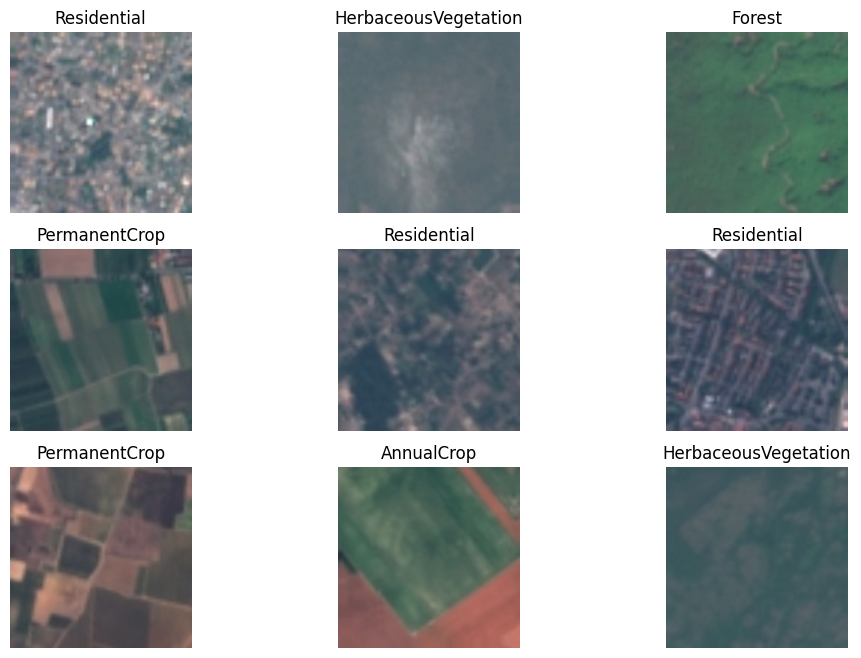

In [7]:
from fastai.vision.all import *

# Assuming you have already created your DataLoaders object
# dls = ImageDataLoaders.from_folder(path, ...)

# Show a batch of images
dls.show_batch(figsize=(12, 8))


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

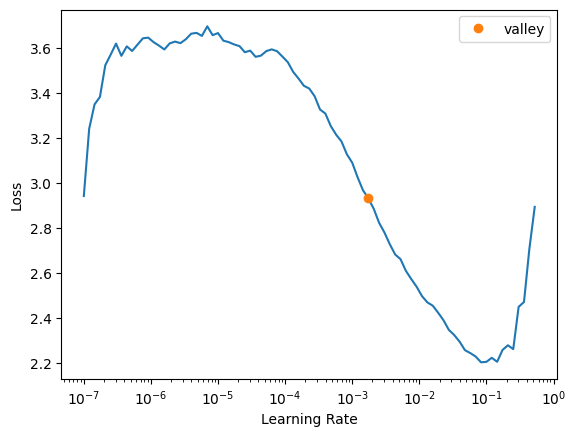

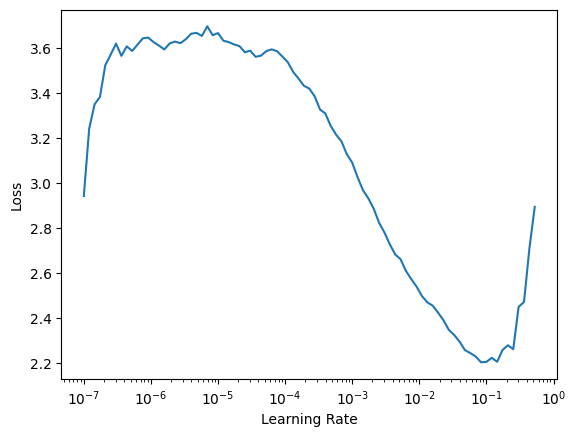

In [6]:
from fastai.vision.all import *

# Create your DataBlock and DataLoaders as before
# Assuming you have already created `dls` and `learn`:

# Find the optimal learning rate
learn.lr_find()

# Plot the learning rate finder results
learn.recorder.plot_lr_find(suggestion=True)  # This plots the results


In [8]:
lr = 3.63E-03
learn.fit_one_cycle(6, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.571300,0.381900,0.123148,03:05
1,0.476549,0.257364,0.088889,03:06
2,0.353095,0.172490,0.060556,03:05
3,0.276497,0.137871,0.045741,03:05
4,0.221291,0.119060,0.041296,03:07
5,0.210992,0.124624,0.043333,03:05


In [11]:
# save the model
learn.save('resnet50_mod_01')

Path('models/resnet50_mod_01.pth')

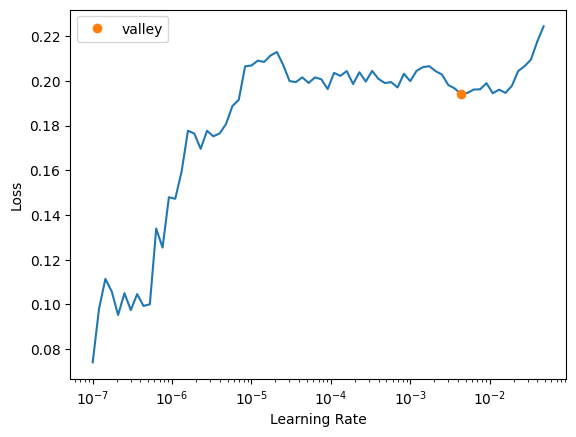

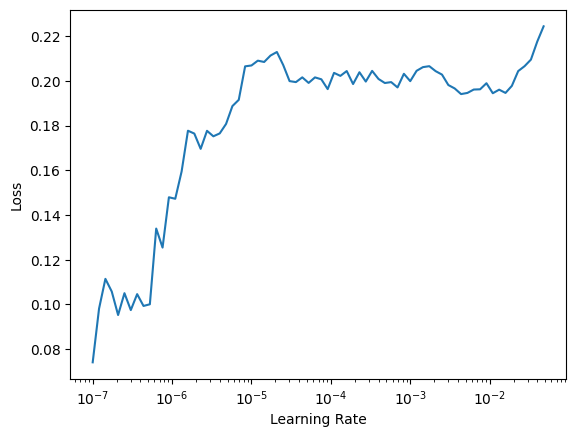

In [12]:
# load the model
learn.load('resnet50_mod_01')
learn.lr_find()
learn.recorder.plot_lr_find()

In [13]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,error_rate,time
0,0.149713,0.094752,0.034630,04:02
1,0.155156,0.083621,0.028704,04:02
2,0.148749,0.083459,0.029630,04:02


In [ ]:
learn.save('resnet50_mod_02')

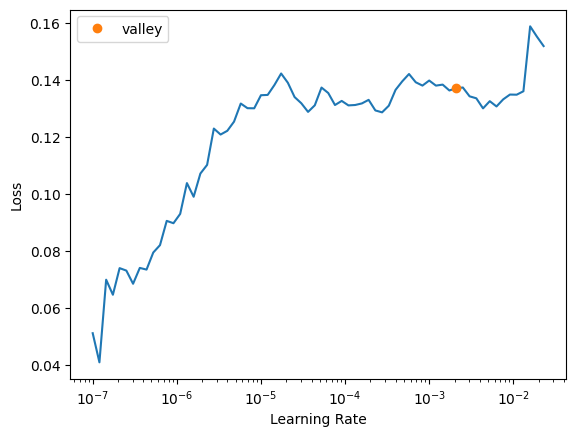

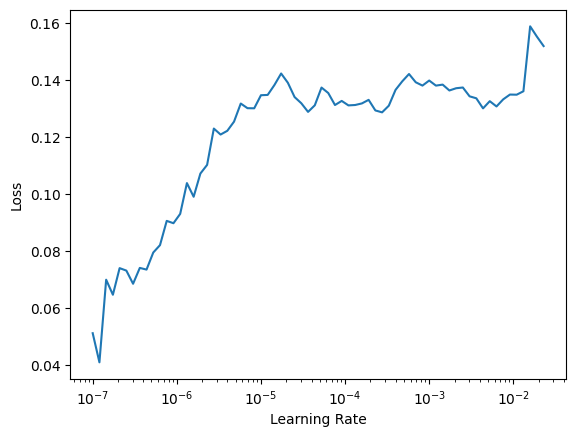

In [ ]:
learn.freeze()
learn.lr_find()

# Plot learning rate finder results
learn.recorder.plot_lr_find()  # Correct method for plotting the learning rate curve


In [ ]:
learn.load('resnet50_mod_02')
learn.fit_one_cycle(1, slice(1e-5/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.184534,0.085887,0.031296,03:10


In [ ]:
learn.save('resnet50_mod_03')

Path('models/resnet50_mod_03.pth')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

True

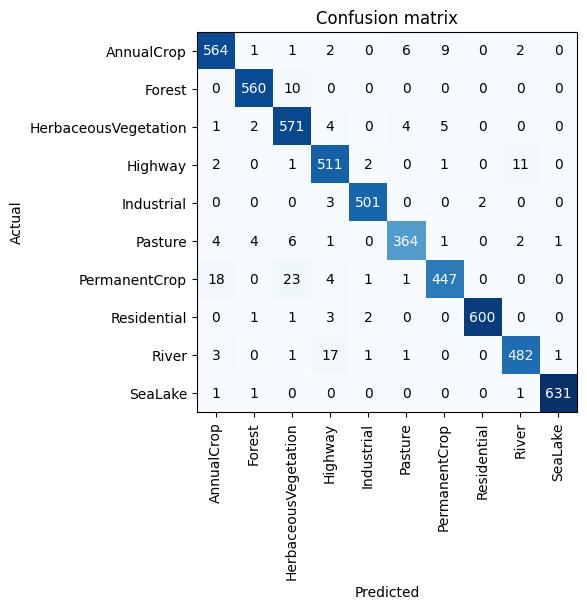

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
interp.most_confused(min_val=5)

[('PermanentCrop', 'HerbaceousVegetation', 23),
 ('PermanentCrop', 'AnnualCrop', 18),
 ('River', 'Highway', 17),
 ('Highway', 'River', 11),
 ('Forest', 'HerbaceousVegetation', 10),
 ('AnnualCrop', 'PermanentCrop', 9),
 ('AnnualCrop', 'Pasture', 6),
 ('Pasture', 'HerbaceousVegetation', 6),
 ('HerbaceousVegetation', 'PermanentCrop', 5)]

In [ ]:
learn.export()

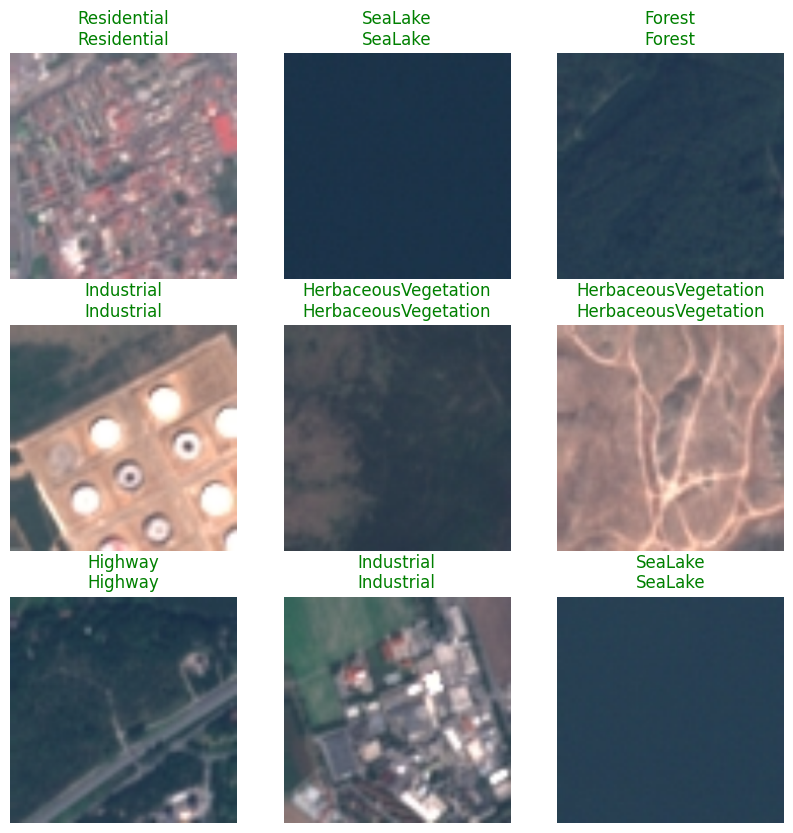

In [ ]:
learn.show_results(max_n=9, figsize=(10,10))  # max_n controls the number of images shown


In [ ]:
path = Path('/content/export.pkl')
learn = load_learner(path)


In [ ]:
# Assuming you have a valid `learn` object loaded with a trained model
classes = learn.dls.vocab
print(classes)  # This will print the list of classes


['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


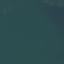

In [ ]:
img = dls.train_ds[5134][0];img

In [ ]:
learn.predict(img)


('SeaLake',
 tensor(9),
 tensor([9.4209e-06, 6.6917e-07, 3.8542e-08, 1.8070e-08, 9.0206e-09, 8.4641e-08,
         2.6652e-09, 8.1369e-09, 4.0165e-08, 9.9999e-01]))

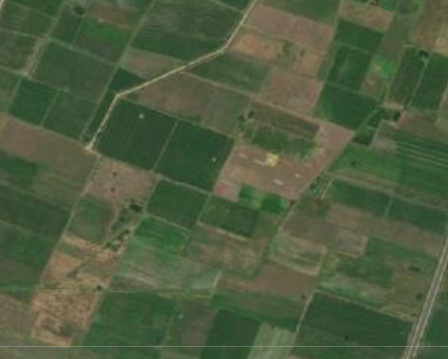

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # This is necessary for displaying images in Colab

# Read the image from a file
img = cv2.imread('/content/drive/MyDrive/CAPSTONE/Sathenapalli.png')

# Display the image
cv2_imshow(img)


In [ ]:
learn.predict(img)


('AnnualCrop',
 tensor(0),
 tensor([9.9983e-01, 4.4753e-09, 3.8990e-07, 4.1465e-05, 3.6453e-09, 2.5415e-08,
         1.2902e-04, 1.2762e-08, 6.0567e-07, 1.6270e-07]))